In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty

%load_ext autoreload
%autoreload 2

#aux
clocks = pickle.load(open('subdata/clock_coefs.pkl', 'rb'))

In [111]:
######### pair patterns ######

# dfa = ...
# meta = ...

# dfr = ...
# metr = ...

# methclock = ...

#day0 = ...
#day1 = ...

# GSE90124 -> GSE54848 (Aging Skin -> Full reprogramming)

In [2]:
#Aging
dfa = pd.read_csv('data/GSE90124/GSE90124_betasProcessed_Non-normalisedValues_322samples_2016.txt', sep='\t', index_col=0)
meta = pd.read_csv('data/GSE90124/meta.csv', index_col=0)
meta['age'] = meta['characteristics_ch1.2.age at biopsy']
dfa = dfa[meta.index]
print('Age, N sites', len(dfa.index))

#Reprogramming
dfr = pd.read_csv('./data/GSE54848/data.csv', index_col=0)
metr = pd.read_csv('data/GSE54848/meta.csv', index_col=0).loc[dfr.columns]
print('Rep, N sites', len(dfr.index))

#methylclock output
methclock = pd.read_csv('subdata/GSE54848_methylclock_results.csv', index_col=1).drop('Unnamed: 0', axis=1)
methclock['age'] = metr['age']
groupr = methclock.groupby('age').mean()

repday0 = 0
repday1 = 15

Age, N sites 450531
Rep, N sites 485577


## Methylclock models predict different rejuvenation dynamics

/tmp/ipykernel_12555/3954601975.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


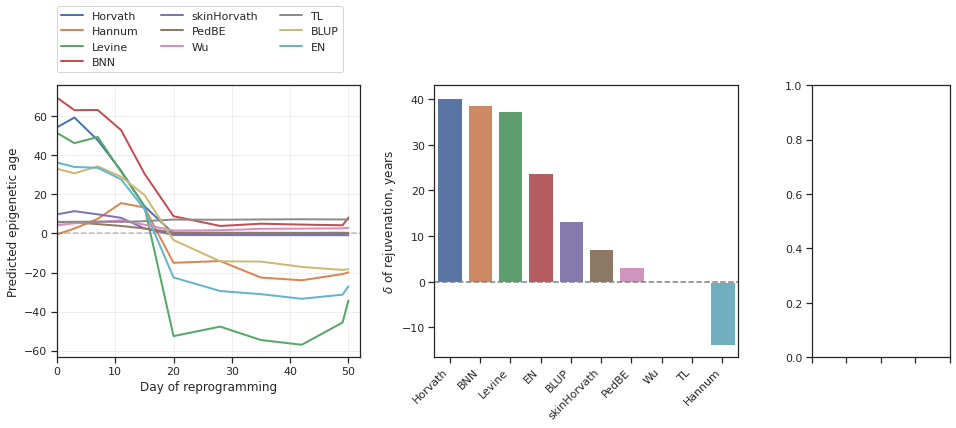

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16,5), gridspec_kw={'width_ratios':[11,11,5]})

#ax0
for c in groupr.columns:
    axes[0].plot(groupr.index, groupr[c], label=c, lw=2)
axes[0].legend(loc=[0.0, 1.05], ncol=3)
axes[0].grid(alpha=0.3)
axes[0].axhline(0, ls='--', alpha=0.5, color='grey')
axes[0].set_xlim([0, 52])
axes[0].set_xlabel('Day of reprogramming')
axes[0].set_ylabel('Predicted epigenetic age')

#ax1
delta_rep = groupr.loc[repday0] - groupr.loc[repday1]
delta_rep = delta_rep.sort_values(ascending=False).to_frame().reset_index()
delta_rep.columns = ['clock', 'delta']

sns.barplot(data=delta_rep, y='delta', x='clock', orient='v', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel(f'$\delta$ of rejuvenation, years')
# axes[1].set_yticks([])
axes[1].axhline(0, color='grey', ls='--')
axes[1].annotate('ElasticNet trained \non different datasets', xy=(10, 92.5), ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

#ax2
# groupr2 = ...
# delta_rep2 = groupr2.loc[0] - groupr2.loc[15]
# delta_rep2 = delta_rep2.sort_values(ascending=False).to_frame().reset_index()
# delta_rep2.columns = ['clock', 'delta']

#call function

# sns.barplot(data=delta_rep2, y='delta', x='clock', orient='v', ax=axes[1], palette='Dark2')
axes[2].annotate('Trained on \nHannum\'s blood \ndataset 71 CpGs', xy=(0, 85))
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.subplots_adjust(wspace=0.3)
plt.show()

## Check covariate shift

In [4]:
#cname = 'Hannum clock (71 CpGs)'
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

389 common sites


In [5]:
pca = PCA(2)
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

/tmp/ipykernel_12555/3838159844.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa_clock.append(Xr_clock))


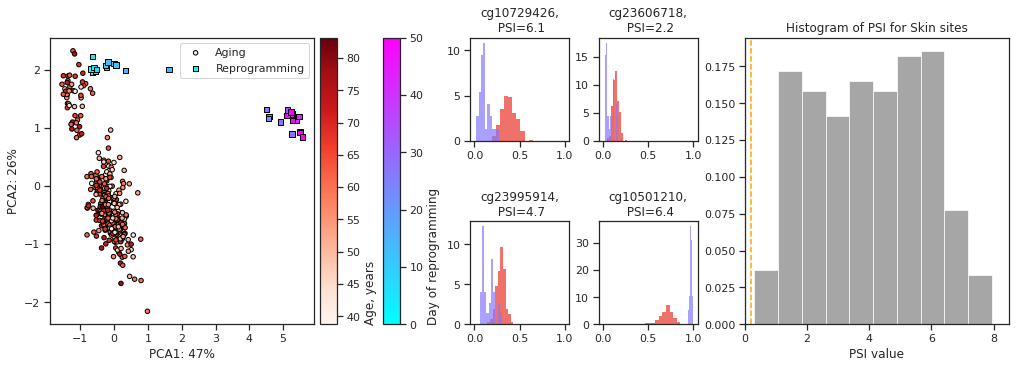

In [6]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

fig = plt.figure(figsize=(14, 5), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig, width_ratios=[ 4,4, 0.5, 0.5, 3,3, 4,4]) 
axcb1 = fig.add_subplot(gs[:, 2])
axcb2 = fig.add_subplot(gs[:, 3])
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 4])
ax2 = fig.add_subplot(gs[0, 5])
ax3 = fig.add_subplot(gs[1, 4])
ax4 = fig.add_subplot(gs[1, 5])
ax5 = fig.add_subplot(gs[:, 6:])

#cbars
cmap_age = mpl.cm.Reds
cmap_rep = mpl.cm.cool
norm_age = mpl.colors.Normalize(vmin=min(ya), vmax=max(ya))
norm_rep = mpl.colors.Normalize(vmin=min(yr), vmax=max(yr))
cb_age = mpl.colorbar.ColorbarBase(axcb1, cmap=cmap_age, norm=norm_age)
cb_rep = mpl.colorbar.ColorbarBase(axcb2, cmap=cmap_rep, norm=norm_rep)
cb_age.set_label('Age, years', loc='bottom')
cb_rep.set_label('Day of reprogramming', loc='bottom')

# ax0 - PCA
ax0.set_title('')
z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=20, label='Aging', 
                      edgecolors='black', cmap=cmap_age)
z2_plot = ax0.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=30, label='Reprogramming', 
                      edgecolors='black', cmap=cmap_rep)
ax0.set_xlabel(f'PCA1: {int(pvar[0]*100)}%')
ax0.set_ylabel(f'PCA2: {int(pvar[1]*100)}%')
ax0.legend()


#top from Hannum clocks sites by absolute pearson correlation with age
# selected_sites = ['cg16867657', 'cg19283806', 'cg06639320', 'cg07082267']

#top sites from Skin clock based on correlation with age
selected_sites = Xa_clock.corrwith(ya).abs().sort_values(ascending=False).index[:4]

#examples of sites + PSIs
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    psi = calculate_shift(np.asarray(Xa_clock[selected_sites[k]])[:, None], 
                          np.asarray(Xr_clock[selected_sites[k]])[:, None],
                          metric_type='psi'
                          ).item()
    ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.7, color='#e93529', bins=10, edgecolor='none')
    ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.7, color='#8678ff', bins=10, edgecolor='none')
    ax_.set_title(f'{selected_sites[k]},\n PSI={round(psi, 1)}')
    ax_.set_xlim([-0.05, 1.05])


# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='psi')

ax5.set_title('Histogram of PSI for Skin sites')
ax5.hist(psis, density=True, alpha=0.7, color='grey')
ax5.axvline(0.2, color='orange', ls='--')
ax5.set_xlim([0, 8.5])
ax5.set_xlabel('PSI value')
plt.show()

/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=axis, keepdims=True)


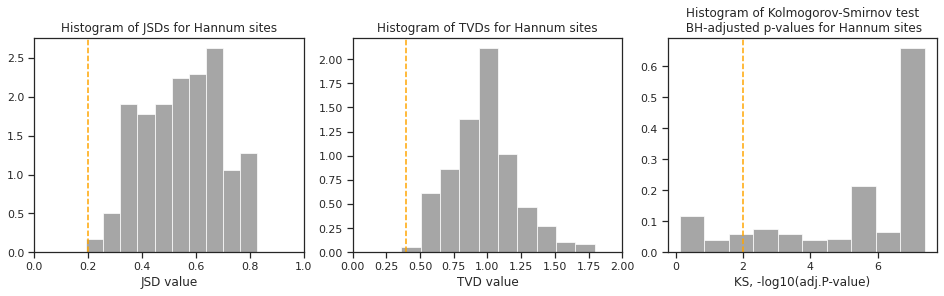

In [7]:
#supplement
from statsmodels.stats.multitest import multipletests

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='jsd')

ax0.set_title('Histogram of JSDs for Hannum sites')
ax0.hist(psis, density=True, alpha=0.7, color='grey')
ax0.axvline(0.2, color='orange', ls='--')
ax0.set_xlim([0, 1])
ax0.set_xlabel('JSD value')

psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='tvd')

ax1.set_title('Histogram of TVDs for Hannum sites')
ax1.hist(psis, density=True, alpha=0.7, color='grey')
ax1.axvline(0.4, color='orange', ls='--')
ax1.set_xlim([0, 2])
ax1.set_xlabel('TVD value')

ks, ksp = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='ks')
kspa = multipletests(ksp, method='hs')[1]
ax2.set_title('Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Hannum sites')
ax2.hist(-np.log10(kspa), density=True, alpha=0.7, color='grey')
ax2.axvline(-np.log10(0.01), color='orange', ls='--')
#ax2.set_xlim([0, 1])
ax2.set_xlabel('KS, -log10(adj.P-value)')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [8]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.10, random_state=10)

Step 1 results:
R2 train = 0.921
MAE train = 2.095
R2 test = 0.829
MAE test = 2.796
------------------------------
Step 2 results:
R2 train = 0.759
MAE train = 3.33
R2 test = 0.646
MAE test = 4.436
------------------------------


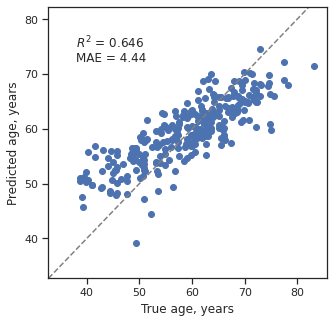

In [9]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80))

Step 1 results:
R2 train = 0.921
MAE train = 2.095
------------------------------
Step 2 results:
R2 test = -32.794
MAE test = 52.718
------------------------------


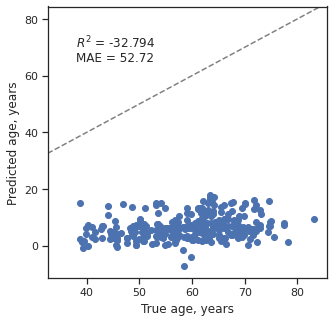

In [10]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80))

## Epistemic uncertainty estimation with Gaussian Process Regressor

### univariate case

R2 train = 0.35748088036028736
R2 test = 0.3226217048499086
MAE train = 5.832072825591856
MAE test = 6.633871547224904
------------------------------
Resulting kernel: 47.6**2 * RBF(length_scale=0.639) + WhiteKernel(noise_level=52.1)


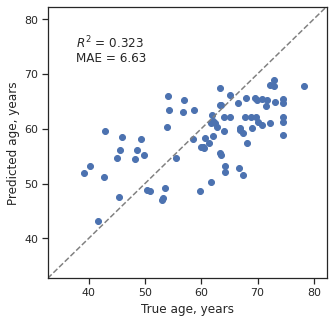

In [13]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

sites_ = dfa.loc[sites].T.corrwith(ya).sort_values(ascending=False).index[[0]]
#sites_ = ['cg16867657'] #'cg16867657', 'cg06639320', 'cg22454769', 'cg24079702', 'cg14361627']

Xa_clock = dfa.loc[[sites_[0]]].T
Xr_clock = dfr.loc[[sites_[0]]].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80))

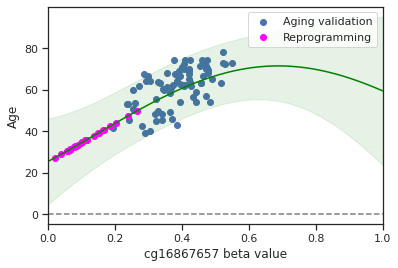

In [14]:
idsort = np.argsort(X_test.iloc[:, 0]).values
x_test = X_test.iloc[idsort, :]
y_test_predict, y_test_std = model.predict(x_test, return_std=True)

x_test2 = np.linspace(0, 1, 100)[:, None]
y_test_predict2, y_test_std2 = model.predict(x_test2, return_std=True)
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plt.scatter(x_test.iloc[:, 0], y_test[idsort], label='Aging validation')
# plt.scatter(x_test.iloc[:, 0], y_test_predict)
#plt.fill_between(x_test.iloc[:, 0], y_test_predict + 2*y_test_std, y_test_predict - 2*y_test_std, alpha=0.5)
plt.plot(x_test2[:, 0], y_test_predict2,color='green')
plt.fill_between(x_test2[:, 0], 
                 y_test_predict2 + 2*y_test_std2, 
                 y_test_predict2 - 2*y_test_std2, 
                 alpha=0.1, color='green')

plt.scatter(Xr_clock.iloc[:, 0], y_test_predict_r, color='magenta', label='Reprogramming')
plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel('cg16867657 beta value')
plt.legend()
plt.show()

### multivariate case

R2 train = 0.9725021329929877
R2 test = 0.8661882466989594
MAE train = 1.2045626614197495
MAE test = 2.724754312472434
------------------------------
Resulting kernel: 98**2 * RBF(length_scale=11.9) + WhiteKernel(noise_level=5.51)


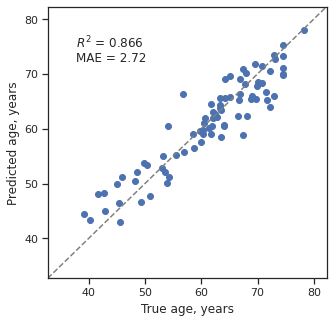

In [11]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80))

Avg uncertainty std: 23.02733924145709
P-value of rejuvenation effect between 0 and 15 days is 0.2794595589739626


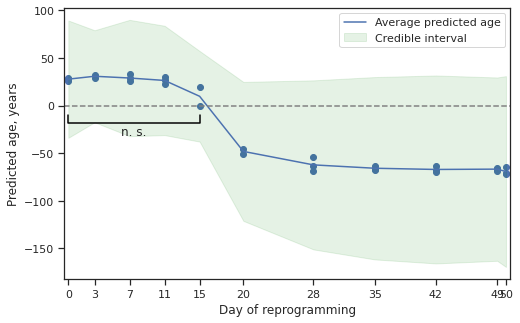

In [12]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr, y_test_predict_r, y_test_std_r, days=(repday0, repday1), nstd=2, dh=0.07, barh=0.03)


# GSE90124 -> GSE165179 (Aging Skin -> Transient reprogramming)

In [36]:
# #reprogramming data, Gill, Illumina EPIC, source=(https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE165180)
#Aging
dfa = pd.read_csv('data/GSE90124/GSE90124_betasProcessed_Non-normalisedValues_322samples_2016.txt', sep='\t', index_col=0)
meta = pd.read_csv('data/GSE90124/meta.csv', index_col=0)
meta['age'] = meta['characteristics_ch1.2.age at biopsy']
dfa = dfa[meta.index]
print('Age, N sites', len(dfa.index))

#rep
dfr = pd.read_csv('data/GSE165179/data_processed.txt', index_col=0)
metr = pd.read_csv('data/GSE165179/meta.csv', index_col=0)
metr['age'] = metr['Day']
print('Rep, N sites', len(dfr.index))

#methylclock output
methclock = pd.read_csv('subdata/GSE165179_methylclock_results.csv', index_col=1).drop('Unnamed: 0', axis=1)
methclock.index = metr.index
methclock['age'] = metr['age']


filt = ['Fibroblast', 'Transient reprogramming intermediate', 'iPSC']
cond = metr['Condition'].isin(filt)

metr = metr[cond]
dfr = dfr.loc[:, cond]
methclock = methclock[cond].dropna(axis=1)
print(metr['Condition'].unique())

groupr = methclock.groupby('age').mean()

repday0 = 0
repday1 = 17

Age, N sites 450531
Rep, N sites 865859
['Fibroblast' 'Transient reprogramming intermediate' 'iPSC']


## Methylclock models predict different rejuvenation dynamics

/tmp/ipykernel_47507/3954601975.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


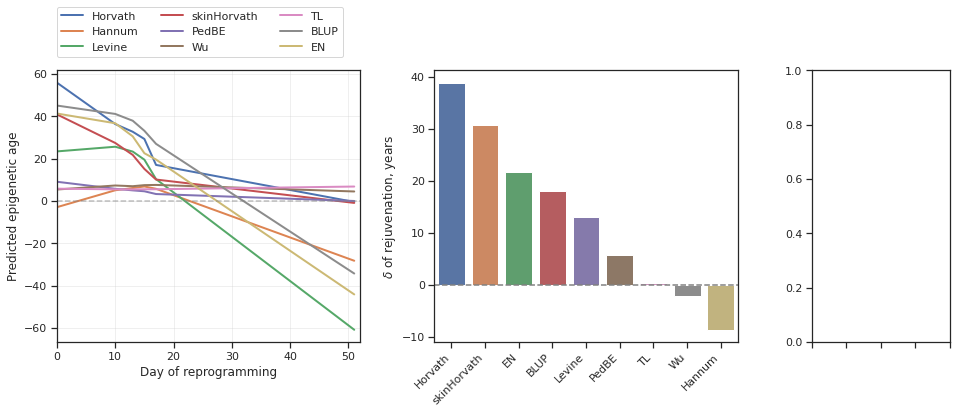

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(16,5), gridspec_kw={'width_ratios':[11,11,5]})

#ax0
for c in groupr.columns:
    axes[0].plot(groupr.index, groupr[c], label=c, lw=2)
axes[0].legend(loc=[0.0, 1.05], ncol=3)
axes[0].grid(alpha=0.3)
axes[0].axhline(0, ls='--', alpha=0.5, color='grey')
axes[0].set_xlim([0, 52])
axes[0].set_xlabel('Day of reprogramming')
axes[0].set_ylabel('Predicted epigenetic age')

#ax1
delta_rep = groupr.loc[repday0] - groupr.loc[repday1]
delta_rep = delta_rep.sort_values(ascending=False).to_frame().reset_index()
delta_rep.columns = ['clock', 'delta']

sns.barplot(data=delta_rep, y='delta', x='clock', orient='v', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel(f'$\delta$ of rejuvenation, years')
# axes[1].set_yticks([])
axes[1].axhline(0, color='grey', ls='--')
axes[1].annotate('ElasticNet trained \non different datasets', xy=(10, 92.5), ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

#ax2
# groupr2 = ...
# delta_rep2 = groupr2.loc[0] - groupr2.loc[15]
# delta_rep2 = delta_rep2.sort_values(ascending=False).to_frame().reset_index()
# delta_rep2.columns = ['clock', 'delta']

#call function

# sns.barplot(data=delta_rep2, y='delta', x='clock', orient='v', ax=axes[1], palette='Dark2')
axes[2].annotate('Trained on \nHannum\'s blood \ndataset 71 CpGs', xy=(0, 85))
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.subplots_adjust(wspace=0.3)
plt.show()

## Check covariate shift

In [38]:
#cname = 'Hannum clock (71 CpGs)'
cname = 'Skin clock (391 CpGs)'
clock = clocks[cname]
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

389 common sites


/tmp/ipykernel_47507/3798869114.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca.fit(Xa_clock.append(Xr_clock))


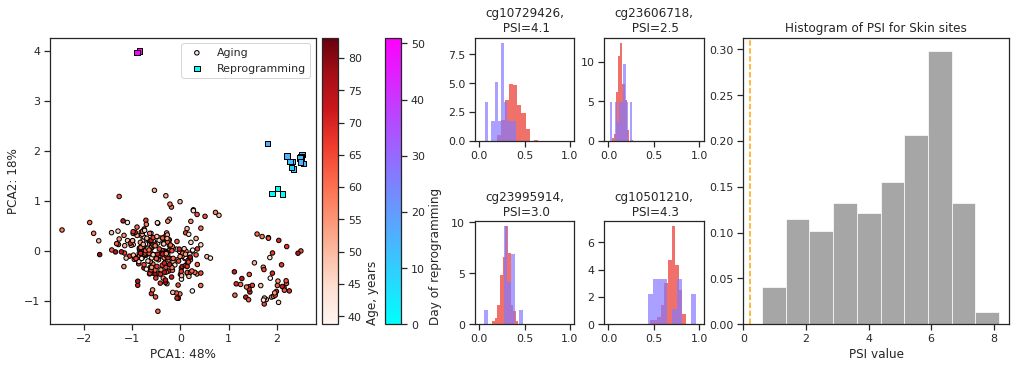

In [40]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

pca = PCA(2)
pca.fit(Xa_clock.append(Xr_clock))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

fig = plt.figure(figsize=(14, 5), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig, width_ratios=[ 4,4, 0.5, 0.5, 3,3, 4,4]) 
axcb1 = fig.add_subplot(gs[:, 2])
axcb2 = fig.add_subplot(gs[:, 3])
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 4])
ax2 = fig.add_subplot(gs[0, 5])
ax3 = fig.add_subplot(gs[1, 4])
ax4 = fig.add_subplot(gs[1, 5])
ax5 = fig.add_subplot(gs[:, 6:])

#cbars
cmap_age = mpl.cm.Reds
cmap_rep = mpl.cm.cool
norm_age = mpl.colors.Normalize(vmin=min(ya), vmax=max(ya))
norm_rep = mpl.colors.Normalize(vmin=min(yr), vmax=max(yr))
cb_age = mpl.colorbar.ColorbarBase(axcb1, cmap=cmap_age, norm=norm_age)
cb_rep = mpl.colorbar.ColorbarBase(axcb2, cmap=cmap_rep, norm=norm_rep)
cb_age.set_label('Age, years', loc='bottom')
cb_rep.set_label('Day of reprogramming', loc='bottom')

# ax0 - PCA
ax0.set_title('')
z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=20, label='Aging', 
                      edgecolors='black', cmap=cmap_age)
z2_plot = ax0.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=30, label='Reprogramming', 
                      edgecolors='black', cmap=cmap_rep)
ax0.set_xlabel(f'PCA1: {int(pvar[0]*100)}%')
ax0.set_ylabel(f'PCA2: {int(pvar[1]*100)}%')
ax0.legend()


#top from Hannum clocks sites by absolute pearson correlation with age
# selected_sites = ['cg16867657', 'cg19283806', 'cg06639320', 'cg07082267']

#top sites from Skin clock based on correlation with age
selected_sites = Xa_clock.corrwith(ya).abs().sort_values(ascending=False).index[:4]

#examples of sites + PSIs
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    psi = calculate_shift(np.asarray(Xa_clock[selected_sites[k]])[:, None], 
                          np.asarray(Xr_clock[selected_sites[k]])[:, None],
                          metric_type='psi'
                          ).item()
    ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.7, color='#e93529', bins=10, edgecolor='none')
    ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.7, color='#8678ff', bins=10, edgecolor='none')
    ax_.set_title(f'{selected_sites[k]},\n PSI={round(psi, 1)}')
    ax_.set_xlim([-0.05, 1.05])


# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='psi')

ax5.set_title('Histogram of PSI for Skin sites')
ax5.hist(psis, density=True, alpha=0.7, color='grey')
ax5.axvline(0.2, color='orange', ls='--')
ax5.set_xlim([0, 8.5])
ax5.set_xlabel('PSI value')
plt.show()

/home/shappiron/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=axis, keepdims=True)


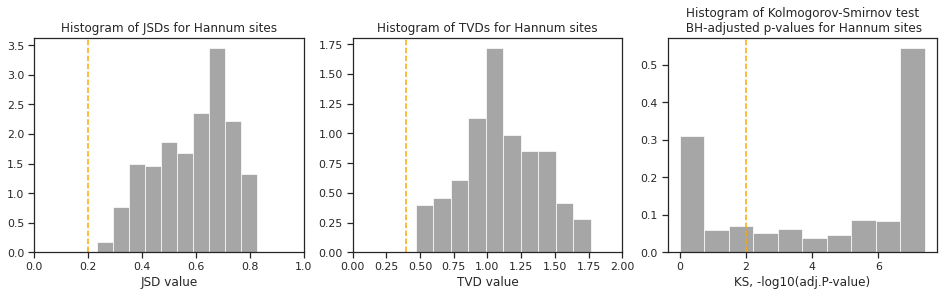

In [41]:
#supplement
from statsmodels.stats.multitest import multipletests

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# ax5 - overall PSI hist
psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='jsd')

ax0.set_title('Histogram of JSDs for Hannum sites')
ax0.hist(psis, density=True, alpha=0.7, color='grey')
ax0.axvline(0.2, color='orange', ls='--')
ax0.set_xlim([0, 1])
ax0.set_xlabel('JSD value')

psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='tvd')

ax1.set_title('Histogram of TVDs for Hannum sites')
ax1.hist(psis, density=True, alpha=0.7, color='grey')
ax1.axvline(0.4, color='orange', ls='--')
ax1.set_xlim([0, 2])
ax1.set_xlabel('TVD value')

ks, ksp = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='ks')
kspa = multipletests(ksp, method='hs')[1]
ax2.set_title('Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Hannum sites')
ax2.hist(-np.log10(kspa), density=True, alpha=0.7, color='grey')
ax2.axvline(-np.log10(0.01), color='orange', ls='--')
#ax2.set_xlim([0, 1])
ax2.set_xlabel('KS, -log10(adj.P-value)')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [42]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.10, random_state=10)

Step 1 results:
R2 train = 0.921
MAE train = 2.095
R2 test = 0.829
MAE test = 2.796
------------------------------
Step 2 results:
R2 train = 0.759
MAE train = 3.33
R2 test = 0.646
MAE test = 4.436
------------------------------


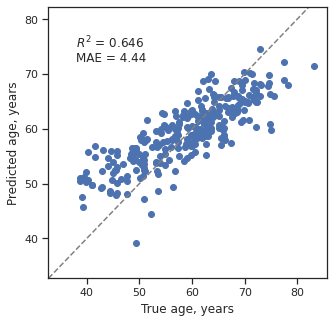

In [43]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80))

Step 1 results:
R2 train = 0.921
MAE train = 2.095
------------------------------
Step 2 results:
R2 test = -13.984
MAE test = 34.344
------------------------------


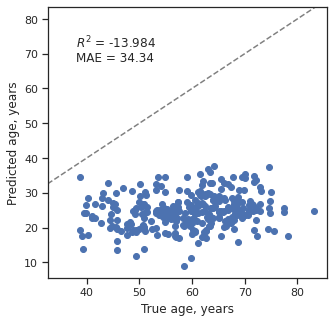

In [44]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(35, 80))

## Epistemic uncertainty estimation with Gaussian Process Regressor

### univariate case

R2 train = 0.3574808738436459
R2 test = 0.32262170521174904
MAE train = 5.832072871086473
MAE test = 6.633871563253779
------------------------------
Resulting kernel: 47.6**2 * RBF(length_scale=0.639) + WhiteKernel(noise_level=52.1)


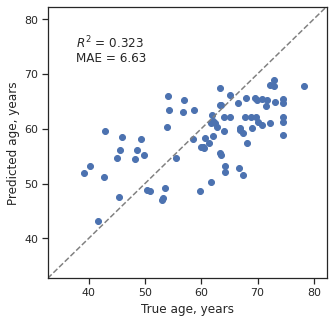

In [45]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

sites_ = dfa.loc[sites].T.corrwith(ya).sort_values(ascending=False).index[[0]]
#sites_ = ['cg16867657'] #'cg16867657', 'cg06639320', 'cg22454769', 'cg24079702', 'cg14361627']

Xa_clock = dfa.loc[[sites_[0]]].T
Xr_clock = dfr.loc[[sites_[0]]].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80))

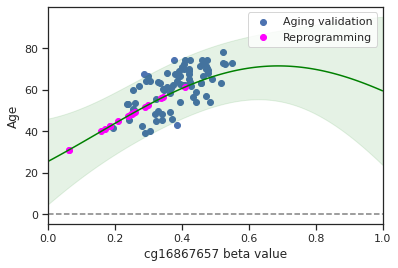

In [46]:
idsort = np.argsort(X_test.iloc[:, 0]).values
x_test = X_test.iloc[idsort, :]
y_test_predict, y_test_std = model.predict(x_test, return_std=True)

x_test2 = np.linspace(0, 1, 100)[:, None]
y_test_predict2, y_test_std2 = model.predict(x_test2, return_std=True)
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plt.scatter(x_test.iloc[:, 0], y_test[idsort], label='Aging validation')
# plt.scatter(x_test.iloc[:, 0], y_test_predict)
#plt.fill_between(x_test.iloc[:, 0], y_test_predict + 2*y_test_std, y_test_predict - 2*y_test_std, alpha=0.5)
plt.plot(x_test2[:, 0], y_test_predict2,color='green')
plt.fill_between(x_test2[:, 0], 
                 y_test_predict2 + 2*y_test_std2, 
                 y_test_predict2 - 2*y_test_std2, 
                 alpha=0.1, color='green')

plt.scatter(Xr_clock.iloc[:, 0], y_test_predict_r, color='magenta', label='Reprogramming')
plt.xlim([0, 1.0])
plt.axhline(0, color='grey', ls='--')
plt.ylabel('Age')
plt.xlabel('cg16867657 beta value')
plt.legend()
plt.show()

### multivariate case

R2 train = 0.9725020822666749
R2 test = 0.8661882838175858
MAE train = 1.2045637882920401
MAE test = 2.7247539544269834
------------------------------
Resulting kernel: 98**2 * RBF(length_scale=11.9) + WhiteKernel(noise_level=5.51)


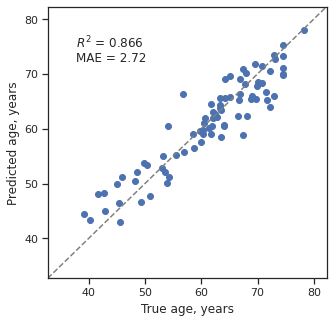

In [47]:
# case with dim X > 1
# clock = clocks['Hannum clock (71 CpGs)']
clock = clocks['Skin clock (391 CpGs)']
sites = clock.index.intersection(dfr.index).intersection(dfa.index)

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age'].values

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(35, 80))

Avg uncertainty std: 17.314481421621185
P-value of rejuvenation effect between 0 and 17 days is 0.013612058500231505


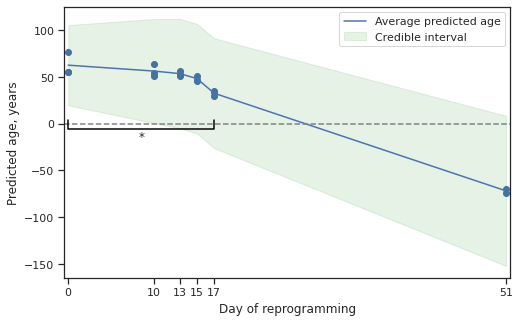

In [51]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr, y_test_predict_r, y_test_std_r, days=(repday0, repday1), nstd=2, dh=0.1, barh=0.03)
